## Modules
Needed to use non-Python functionalities already programmed by someone else.

In [1]:
# Used to cast the polygons into np.arrays and afterwards transpose them easily with the .T function
import numpy as np
import matplotlib.pyplot as plt    # to plot the counties
# Used to determine which part of the plot should be saved
from matplotlib.transforms import Bbox

# Used to underline text in plots
from matplotlib import rc
# To add a colorbar to the plot of the matrix
from mpl_toolkits.axes_grid1 import make_axes_locatable
# Used to navigate the directories and check for files
import os
# backup directory of this file, because the working directory is changed to save files
cor_mx_by_pop_density_districts_directory = os.getcwd()

## Get the Data
Read the file ["Readme.ipynb"](Readme.ipynb) or check out the files ["get_data.ipynb"](get_data.ipynb) and ["get_geographical_data_of_german_counties.ipynb"](get_geographical_data_of_german_counties.ipynb) for more information about the data collection.

In [2]:
os.chdir(".."), os.chdir("..")   # move two directories up
%run color_scheme.ipynb
os.chdir("collect_data")
%run get_data.ipynb
os.chdir(cor_mx_by_pop_density_districts_directory)    # return to original directory

Polished county data from file is ready to go!
Polished covid19 data from file is ready to go!


## Function to calculate the probability of correlations between two arrays

In [3]:
def sort_AdmUnitIDs_by_population_density():
    districts_by_population_density = dict()
    for districtID, district in districts.items():
        if district['population_density'] in districts_by_population_density.keys():
            raise Exception("The population density " + str(district['population_density']) +
                            "seems to be related to two counties")
        else:
            districts_by_population_density[district['population_density']] = districtID
    pop_densitys = list(districts_by_population_density.keys())
    pop_densitys.sort()
    return [districts_by_population_density[e] for e in pop_densitys]

In [4]:
# AdmUnitIds = list(covid19.keys())
AdmUnitIds = sort_AdmUnitIDs_by_population_density()

In [5]:
AdmUnitIds

['130',
 '120',
 '150',
 '72',
 '33',
 '93',
 '92',
 '160',
 '66',
 '94',
 '96',
 '34',
 '71',
 '10',
 '97',
 '65',
 '31',
 '146',
 '84',
 '145',
 '32',
 '83',
 '95',
 '147',
 '91',
 '73',
 '57',
 '55',
 '100',
 '81',
 '82',
 '59',
 '64',
 '53',
 '51',
 '40',
 '20',
 '110']

In [6]:
def get_correlation_matrix(get_max_correlation_not_sum = True, max_shift = 50):
    correlation_matrix = [[0 for c2 in range(len(AdmUnitIds))]
                          for c1 in range(len(AdmUnitIds))]
    for AdmUnitId in AdmUnitIds:
        for second_AdmUnitId in AdmUnitIds:
            i1, i2 = (AdmUnitIds.index(AdmUnitId), AdmUnitIds.index(second_AdmUnitId))
            # if AdmUnitId1 == AdmUnitId2: continue
            if (correlation_matrix[i1][i2] != 0): continue    # Already set
            correlation = districts[AdmUnitId]["correlation"][second_AdmUnitId].copy()
            offset = max_shift + 1
            while get_max_correlation_not_sum and abs(offset) > max_shift:
                # get the shift with the highest correlation probability
                offset = non_county_specific_data[
                    "correlation_position_array2_to_array1"][np.argmax(correlation)]
                correlation[np.argmax(correlation)] = 0
            if not(get_max_correlation_not_sum):    # sum up all probabilities
                lc = len(correlation)//2
                if (len(correlation[:lc]) != len(correlation[lc+1:])):
                    raise Exception("Len(correlation) not correct)")
                if (len(correlation[lc-max_shift:lc]) !=
                    len(correlation[lc:lc+max_shift])):
                    raise Exception("Len(correlation) aslökdfjaslö")
                offset = (-sum(correlation[lc-max_shift:lc]) +
                          sum(correlation[lc:lc+max_shift]))
            correlation_matrix[i1][i2] = offset
            correlation_matrix[i2][i1] = -offset
    return correlation_matrix

In [7]:
correlation_matrizes = list()
matrix_configurations = [(False, 14), (True, 14), (False, 30), 
                         (True, 30),(False, 50), (True, 50)]
for config in matrix_configurations:
    correlation_matrizes.append(get_correlation_matrix(config[0], config[1]))

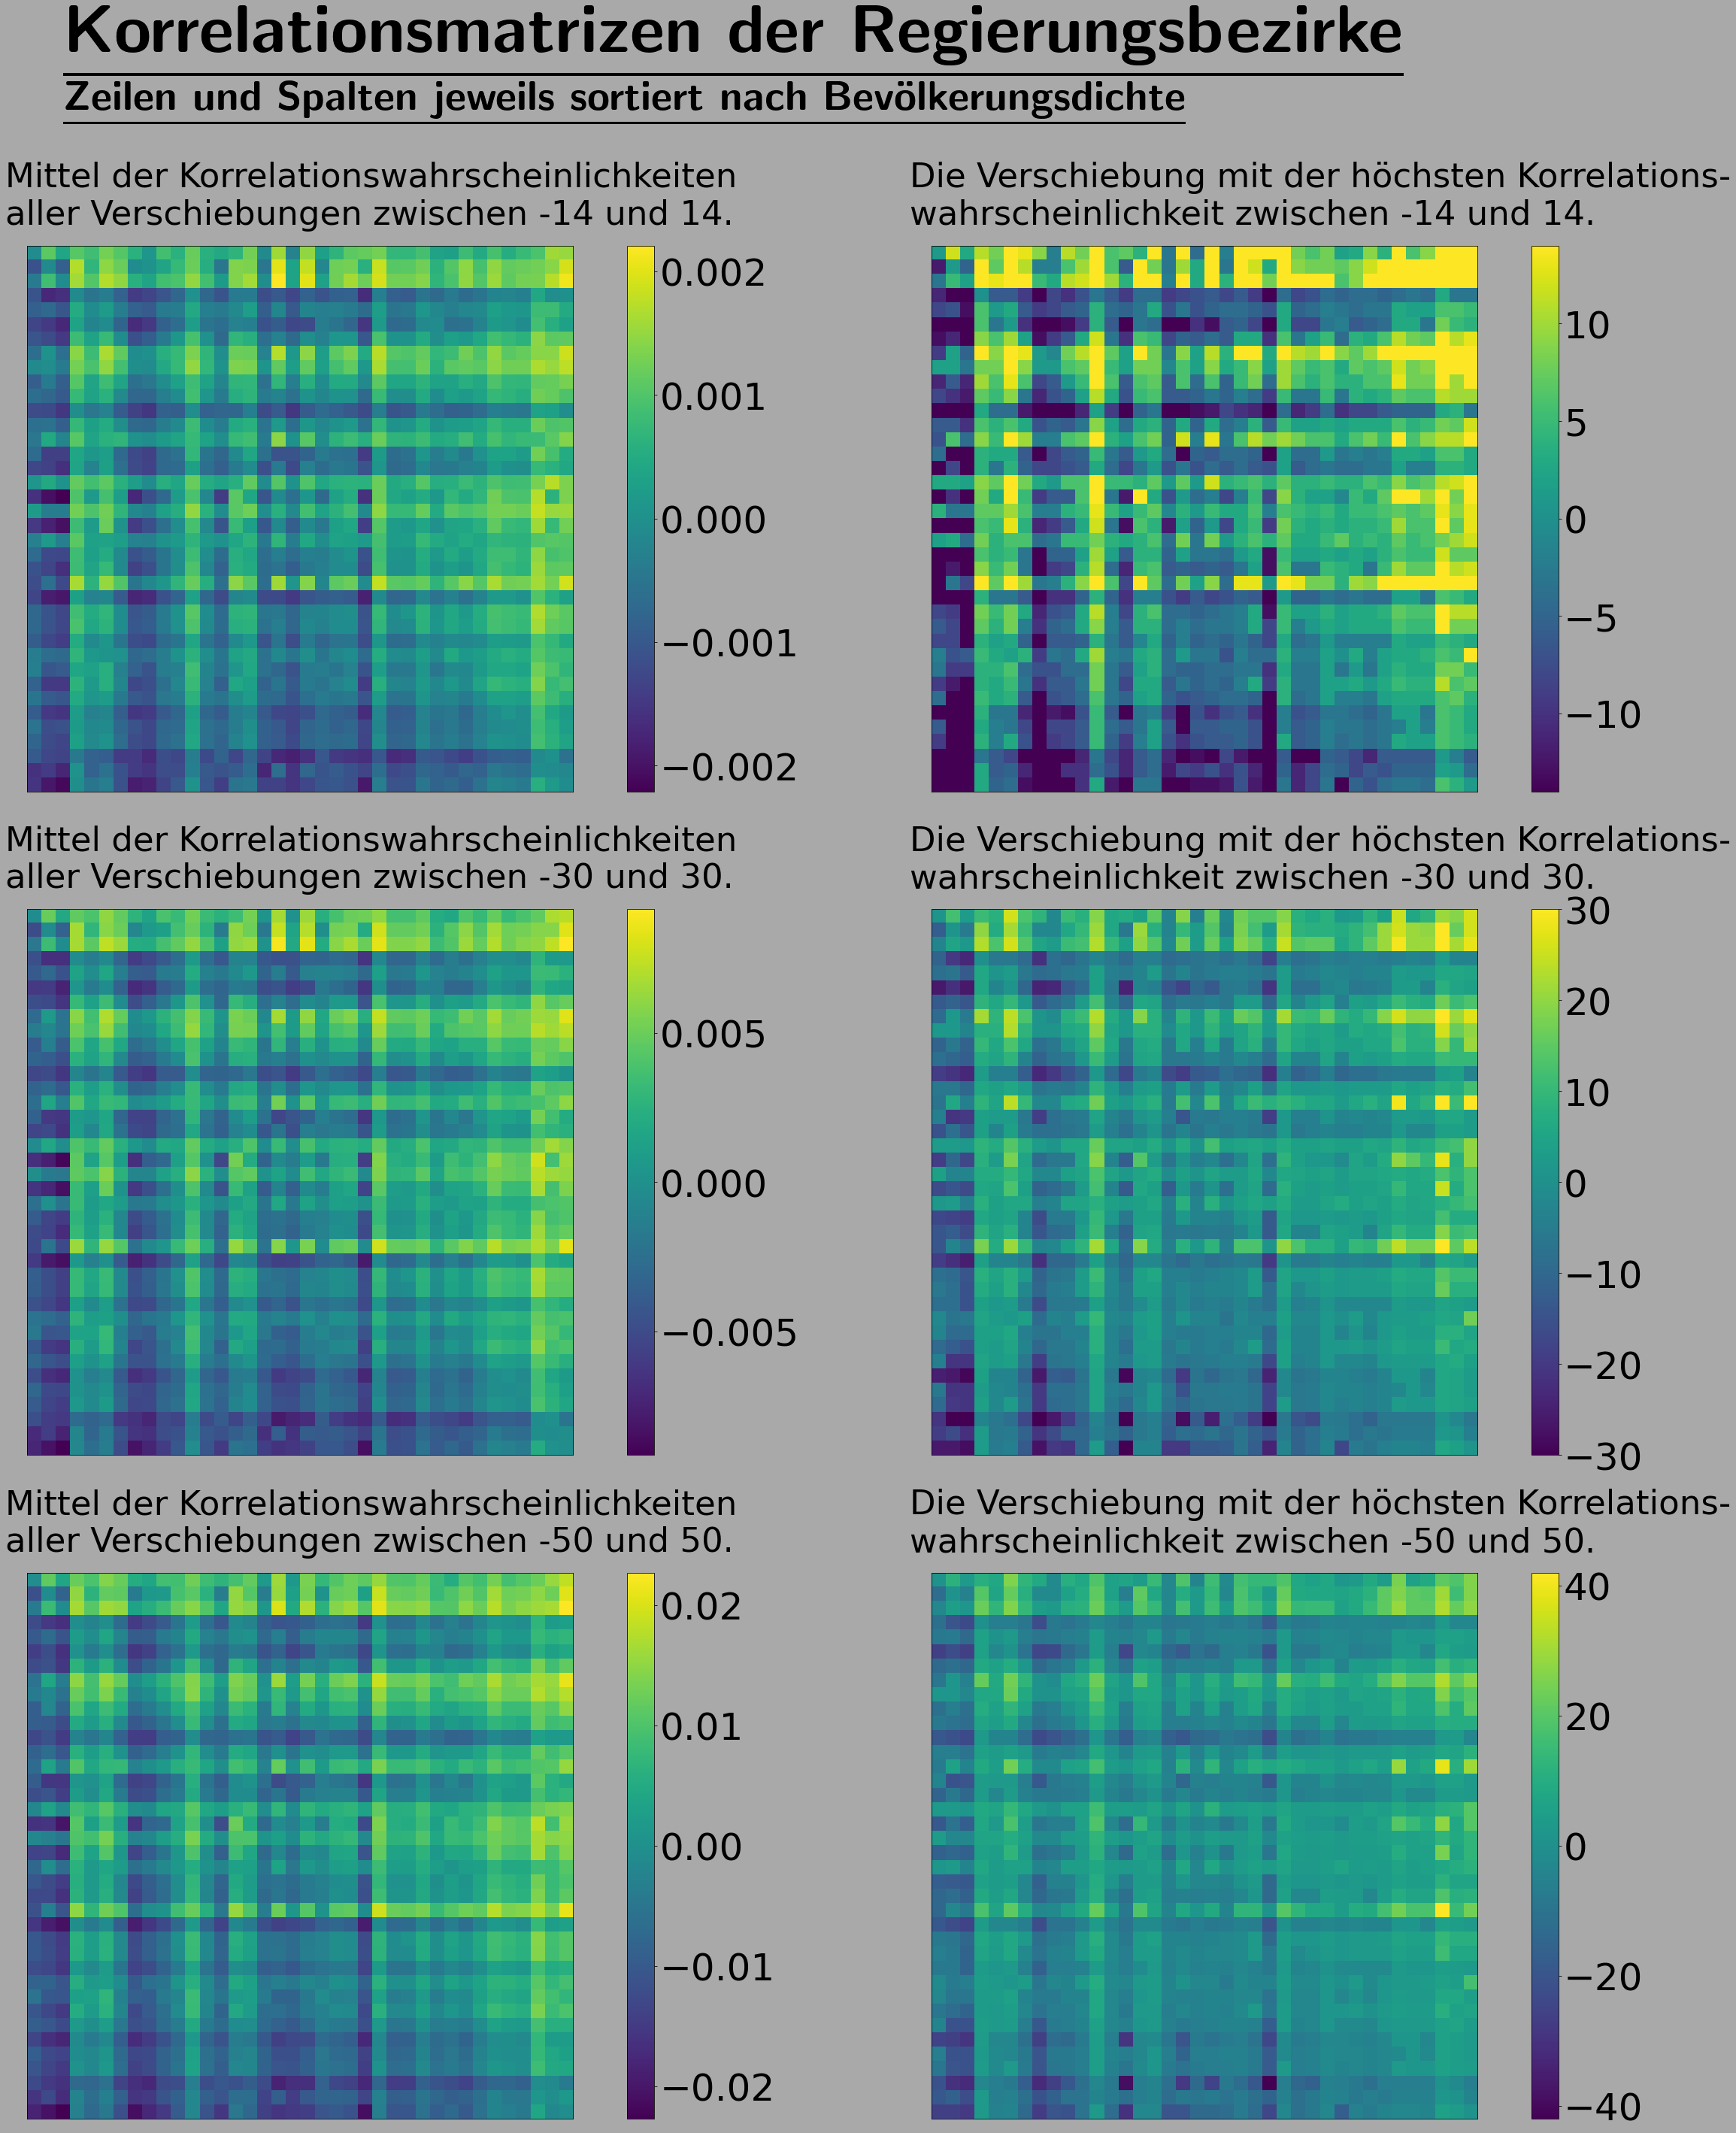

In [8]:
fig, ax = plt.subplots(3, 2, figsize = (35, 40), facecolor='darkgrey')
fig.tight_layout(h_pad=15)

ax[0][0].text(2,-14,r'\textbf{\underline{Korrelationsmatrizen der Regierungsbezirke}}',
              fontsize=90, usetex=True)
ax[0][0].text(2,-10,r'\textbf{\underline{Zeilen und Spalten jeweils sortiert nach Bevölkerungsdichte}}',
              fontsize=55, usetex=True)

i = 0
for correlation_matrix in correlation_matrizes:
    axis = ax[i//2][i%2]
    im1 = axis.matshow(correlation_matrix, interpolation='None')
    if matrix_configurations[i][0]:
        shift = str(matrix_configurations[i][1])
        axis.text(-2,-2,"Die Verschiebung mit der höchsten Korrelations-\n" +
                        "wahrscheinlichkeit zwischen -"+shift+" und "+shift+".",
                        fontsize=45)
    else:
        shift = str(matrix_configurations[i][1])
        axis.text(-2,-2,"Mittel der Korrelationswahrscheinlichkeiten\n" +
                       "aller Verschiebungen zwischen -"+shift+" und "+shift+".",
                       fontsize=45)
    divider = make_axes_locatable(axis)
    cax = divider.append_axes('right', size='5%', pad=1)
    axis.axes.get_xaxis().set_visible(False)
    axis.axes.get_yaxis().set_visible(False)
    cbar = fig.colorbar(im1, cax=cax, orientation='vertical')
    cbar.ax.tick_params(labelsize=50)
    i+=1

os.chdir(".."), os.chdir(".."), os.chdir("..")    # move to correct directory
# check if the needed directory is available - otherwise create it
if not(os.path.isdir("results")): os.makedirs("results")
fig.tight_layout(w_pad=-75)
plt.savefig("results/matrizes_pop_density_districts.png")
os.chdir(cor_mx_by_pop_density_districts_directory)    # return to original directory

## Germany with average shift with highest probability

In [9]:
average_correlations = dict()
for row_index in range(len(correlation_matrizes[-1])):
    row = correlation_matrizes[-1][row_index]
    AdmUnitID = AdmUnitIds[row_index]
    # Because the row represents the shift of the second
    # county relative to the first, ralated to this row,
    # we need to take minus to get the average shift of the county
    # relative to all others
    average_correlations[AdmUnitID]=-(sum(row)/len(row))

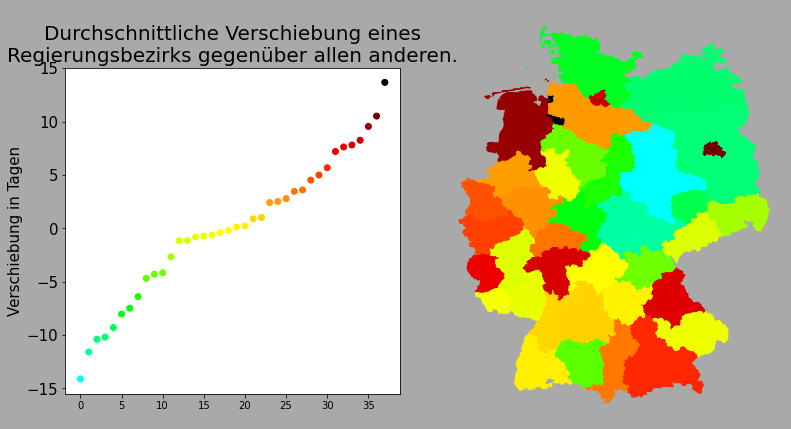

In [10]:
plt.figure(figsize=(6, 6), facecolor='darkgrey')    # enlarge plot
average_correlations_copy = list(average_correlations.values()).copy()
average_correlations_copy.sort()

plt.title("Durchschnittliche Verschiebung eines\nRegierungsbezirks gegenüber allen anderen.",
         fontsize=20)
plt.ylabel("Verschiebung in Tagen", fontsize=15)
plt.yticks(fontsize=15)

colors = list()
for avg_correlation in average_correlations_copy:
    colors.append(color_scheme(avg_correlation, average_correlations_copy))
plt.scatter([i for i in range(len(average_correlations_copy))],
            average_correlations_copy, color=colors)

ax = plt.axes([1, 0.06, 0.79, 0.96], frameon=False)
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
ax.set_facecolor('darkgrey')
for AdmUnitId, correlation in average_correlations.items():
    for AdmUnitID_county in districts[AdmUnitId]["counties"]:
        for polygon in counties_geography[AdmUnitID_county ]['geometry']:
            x,y = np.array(polygon).T
            plt.fill(x, y, color=color_scheme(correlation, average_correlations_copy))

os.chdir(".."), os.chdir(".."), os.chdir("..")    # move to correct directory
# check if the needed directory is available - otherwise create it
if not(os.path.isdir("results")): os.makedirs("results")
plt.savefig("results/average_shift_districts.png",
            facecolor="darkgrey", bbox_inches=Bbox([[-0.7,0.45],[10.7,6]]))
os.chdir(cor_mx_by_pop_density_districts_directory)    # return to original directory

## Germany with probabiility how sure a county is behind

In [11]:
average_correlations = dict()
for row_index in range(len(correlation_matrizes[4])):
    row = correlation_matrizes[4][row_index]
    AdmUnitID = AdmUnitIds[row_index]
    # Because the row represents the shift of the second
    # county relative to the first, related to this row,
    # we need to take minus to get the average shift of the county
    # relative to all others
    average_correlations[AdmUnitID]=-(sum(row)/len(row))

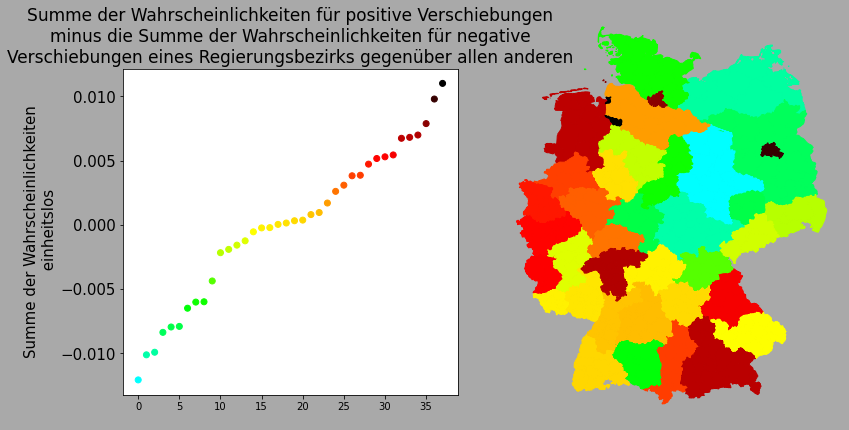

In [12]:
plt.figure(figsize=(6, 6), facecolor='darkgrey')    # enlarge plot
average_correlations_copy = list(average_correlations.values()).copy()
average_correlations_copy.sort()

plt.title("Summe der Wahrscheinlichkeiten für positive Verschiebungen\n"
          "minus die Summe der Wahrscheinlichkeiten für negative\nVerschiebungen "
          "eines Regierungsbezirks gegenüber allen anderen", fontsize=17)
plt.ylabel("Summe der Wahrscheinlichkeiten\n einheitslos", fontsize=15)
plt.yticks(fontsize=15)

colors = list()
for avg_correlation in average_correlations_copy:
    colors.append(color_scheme(avg_correlation, average_correlations_copy))
plt.scatter([i for i in range(len(average_correlations_copy))],
            average_correlations_copy, color=colors)

ax = plt.axes([1, 0.06, 0.79, 0.96], frameon=False)
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
ax.set_facecolor('darkgrey')
for AdmUnitId, correlation in average_correlations.items():
    for AdmUnitID_county in districts[AdmUnitId]["counties"]:
        for polygon in counties_geography[AdmUnitID_county ]['geometry']:
            x,y = np.array(polygon).T
            plt.fill(x, y, color=color_scheme(correlation,
                                              average_correlations_copy))


os.chdir(".."), os.chdir(".."), os.chdir("..")    # move to correct directory
# check if the needed directory is available - otherwise create it
if not(os.path.isdir("results")): os.makedirs("results")
plt.savefig("results/positive_or_negative_shift_districts.png",
            facecolor="darkgrey", bbox_inches=Bbox([[-0.9,0.45],[10.7,6.2]]))
os.chdir(cor_mx_by_pop_density_districts_directory)    # return to original directory